In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-09 23:55:16 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-09 23:55:16 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-09 23:55:16 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
# model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-09 23:55:21 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-09 23:55:21 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-09 23:55:21 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-09 23:55:21 wandb.docker.auth DEBUG    No config file found


In [4]:
# from nnsight import LanguageModel

# lm = LanguageModel(
#     model_key,
#     device_map="auto",
#     dispatch=True,
# )

In [5]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-09 23:55:30 src.models WARNING  google/gemma-2-27b-it not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-09-09 23:55:30 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-09-09 23:55:30 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /google/gemma-2-27b-it/resolve/main/config.json HTTP/1.1" 200 0


2025-09-09 23:55:30 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /google/gemma-2-27b-it/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-09-09 23:55:30 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/google/gemma-2-27b-it/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

2025-09-09 23:55:49 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /google/gemma-2-27b-it/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-09-09 23:55:49 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /google/gemma-2-27b-it/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-09 23:55:49 src.models INFO     loaded model <google/gemma-2-27b-it> | size: 51931.626 MB | dtype: torch.bfloat16 | device: cuda:0


In [7]:
from src.selection.data import SelectOneTask, CountingTask, get_counterfactual_samples_interface

#################################################################################
TASK_CLS = CountingTask
# TASK_CLS = SelectOneTask
prompt_template_idx = 1
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

CountingTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [12]:
from src.selection.data import get_counterfactual_samples_within_task

counterfact_sampler = get_counterfactual_samples_interface[select_task.task_name]

kwargs = {}
if TASK_CLS == CountingTask:
    kwargs["clean_n_options"] = N_DISTRACTORS + 1
    kwargs["patch_n_options"] = N_DISTRACTORS + 1
else:
    kwargs["clean_n_distractors"] = N_DISTRACTORS
    kwargs["patch_n_distractors"] = N_DISTRACTORS
    kwargs["clean_prompt_template_idx"] = prompt_template_idx
    kwargs["patch_prompt_template_idx"] = prompt_template_idx

patch_sample, clean_sample = counterfact_sampler(
    mt=mt,
    task=select_task,
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    distinct_options=True,
    patch_category="fruit",
    clean_category="vehicle",
    **kwargs,
)

# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

print(patch_sample.prompt(), ">>", mt.tokenizer.decode(patch_sample.ans_token_id))
print(clean_sample.prompt(), ">>", mt.tokenizer.decode(clean_sample.ans_token_id))

2025-09-10 00:10:07 src.selection.data DEBUG    clean_category='vehicle' | clean_sample.options=['Truck', 'Pineapple', 'Bus', 'Tractor', 'Helicopter', 'Bike']
2025-09-10 00:10:07 src.selection.data DEBUG    patch_category='fruit' | patch_sample.options=['Scooter', 'Yacht', 'Van', 'Mango', 'Submarine', 'Watermelon']


2025-09-10 00:10:08 src.selection.data ERROR    Prediction mismatch: (2, PredictedToken(token=' One', prob=0.0024566650390625, logit=17.75, token_id=3428, metadata=None))[" "] != 3428[" One"]
2025-09-10 00:10:08 src.selection.data DEBUG    clean_category='vehicle' | clean_sample.options=['Scooter', 'Ambulance', 'Boat', 'Yacht', 'Van', 'Pear']
2025-09-10 00:10:08 src.selection.data DEBUG    patch_category='fruit' | patch_sample.options=['Airplane', 'Mango', 'Orange', 'Apple', 'Helicopter', 'Cherry']
2025-09-10 00:10:08 src.selection.data ERROR    Prediction mismatch: (2, PredictedToken(token=' One', prob=0.00131988525390625, logit=17.375, token_id=3428, metadata=None))[" "] != 3428[" One"]
2025-09-10 00:10:08 src.selection.data DEBUG    clean_category='vehicle' | clean_sample.options=['Ambulance', 'Grape', 'Boat', 'Mango', 'Strawberry', 'Pineapple']
2025-09-10 00:10:08 src.selection.data DEBUG    patch_category='fruit' | patch_sample.options=['Cherry', 'Kiwi', 'Orange', 'Helicopter', 'B

In [13]:
from src.tokens import prepare_input

clean_tokenized = prepare_input(tokenizer=mt, prompts=clean_sample.prompt())
print(mt.tokenizer.decode(clean_tokenized.input_ids[0], skip_special_tokens=False))

<bos>Items: Raspberry, Scooter, Blueberry, Plum, Cherry, Pear
How many vehicles are in this list?
Answer:


In [14]:
from src.tokens import prepare_input
from src.selection.utils import get_first_token_id
from src.functional import interpret_logits, PatchSpec
from itertools import product
from src.utils.typing import TokenizerOutput, ArrayLike
from typing import Optional, Union
from src.functional import get_module_nnsight, untuple, get_hs, predict_next_token
from src.selection.data import SelectionSample
import random
from src.selection.functional import find_quesmark_pos


def layer_wise_patching(
    mt: ModelandTokenizer,
    patch_sample: SelectionSample,
    clean_sample: SelectionSample,
    map_indices: list[int] = {-2: -2, -1: -1},
    consider_ques_pos: bool = True,
):
    clean_tokenized = prepare_input(
        prompts=clean_sample.prompt(), tokenizer=mt, return_offsets_mapping=True
    )
    patch_tokenized = prepare_input(
        prompts=patch_sample.prompt(), tokenizer=mt, return_offsets_mapping=True
    )
    clean_offset_mapping = clean_tokenized.pop("offset_mapping")[0]
    patch_offset_mapping = patch_tokenized.pop("offset_mapping")[0]
    if consider_ques_pos:
        clean_ques_pos = find_quesmark_pos(
            prompt=clean_sample.prompt(),
            tokenizer=mt.tokenizer,
            tokenized=clean_tokenized,
            offset_mapping=clean_offset_mapping,
        )
        patch_ques_pos = find_quesmark_pos(
            prompt=patch_sample.prompt(),
            tokenizer=mt.tokenizer,
            tokenized=patch_tokenized,
            offset_mapping=patch_offset_mapping,
        )
        map_indices[patch_ques_pos] = clean_ques_pos

    random_idx = random.choice(
        list(
            set(list(range(len(clean_sample.options))))
            - {
                patch_sample.obj_idx,
                clean_sample.obj_idx,
                clean_sample.metadata["track_type_obj_idx"],
            }
        )
    )

    track_tokens = {
        "predicate_target": clean_sample.metadata["track_type_obj_token_id"],
        "clean_ans": get_first_token_id(clean_sample.obj, mt.tokenizer, prefix=" "),
        "patch_ans": get_first_token_id(patch_sample.obj, mt.tokenizer, prefix=" "),
        "patch_position": get_first_token_id(
            clean_sample.options[patch_sample.obj_idx], mt.tokenizer, prefix=" "
        ),
        "random_distractor": get_first_token_id(
            clean_sample.options[random_idx], mt.tokenizer, prefix=" "
        ),
    }

    ret = {"track_tokens": track_tokens}

    logit_location = (mt.lm_head_name, -1)
    cache_h_from_locations = list(product(mt.layer_names, list(map_indices.keys())))
    # patch_locations = []
    print(cache_h_from_locations)

    patch_hs = get_hs(
        mt=mt,
        input=patch_tokenized,
        locations=cache_h_from_locations + [logit_location],
        return_dict=True,
    )
    patch_logits = patch_hs[logit_location]
    patch_pred, patch_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=patch_logits,
        interested_tokens=track_tokens.values(),
    )
    logger.debug(f"patch_pred={[str(pred) for pred in patch_pred]}")
    logger.debug(f"patch_track={patch_track}")
    ret["patch_pred"] = patch_pred
    ret["patch_track"] = patch_track

    clean_hs = get_hs(
        mt=mt,
        input=clean_tokenized,
        locations=cache_h_from_locations + [logit_location],
        return_dict=True,
    )
    clean_logits = clean_hs[logit_location]
    clean_pred, clean_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=clean_logits,
        interested_tokens=track_tokens.values(),
    )
    logger.debug(f"clean_pred={[str(pred) for pred in clean_pred]}")
    logger.debug(f"clean_track={clean_track}")
    ret["clean_pred"] = clean_pred
    ret["clean_track"] = clean_track

    layer_wise_patching_results = {}
    for layer in mt.layer_names:
        patch_spec = []
        for patch_tok_idx in map_indices.keys():
            patch_spec.append(
                PatchSpec(
                    location=(layer, map_indices[patch_tok_idx]),
                    patch=patch_hs[(layer, patch_tok_idx)],
                )
            )

        # int_pred, int_track = predict_next_token(
        #     mt=mt,
        #     inputs=clean_tokenized,
        #     token_of_interest=track_tokens.values(),
        #     patches=patch_spec
        # )
        int_hs = get_hs(
            mt=mt,
            input=clean_tokenized,
            locations=[logit_location],
            patches=patch_spec,
            return_dict=True,
        )
        int_logits = int_hs[logit_location]
        int_pred, int_track = interpret_logits(
            tokenizer=mt.tokenizer,
            logits=int_logits,
            interested_tokens=track_tokens.values(),
        )

        logger.debug(f"Layer {layer}: int_pred={[str(pred) for pred in int_pred]}")
        layer_wise_patching_results[layer] = {
            "int_pred": int_pred,
            "int_track": int_track,
        }

    ret["layer_wise_patching_results"] = layer_wise_patching_results
    return ret


patching_result = layer_wise_patching(
    mt=mt,
    patch_sample=patch_sample,
    clean_sample=clean_sample,
    map_indices={-2: -2, -1: -1},
    consider_ques_pos=True,
)

[('model.layers.0', -2), ('model.layers.0', -1), ('model.layers.0', 10), ('model.layers.1', -2), ('model.layers.1', -1), ('model.layers.1', 10), ('model.layers.2', -2), ('model.layers.2', -1), ('model.layers.2', 10), ('model.layers.3', -2), ('model.layers.3', -1), ('model.layers.3', 10), ('model.layers.4', -2), ('model.layers.4', -1), ('model.layers.4', 10), ('model.layers.5', -2), ('model.layers.5', -1), ('model.layers.5', 10), ('model.layers.6', -2), ('model.layers.6', -1), ('model.layers.6', 10), ('model.layers.7', -2), ('model.layers.7', -1), ('model.layers.7', 10), ('model.layers.8', -2), ('model.layers.8', -1), ('model.layers.8', 10), ('model.layers.9', -2), ('model.layers.9', -1), ('model.layers.9', 10), ('model.layers.10', -2), ('model.layers.10', -1), ('model.layers.10', 10), ('model.layers.11', -2), ('model.layers.11', -1), ('model.layers.11', 10), ('model.layers.12', -2), ('model.layers.12', -1), ('model.layers.12', 10), ('model.layers.13', -2), ('model.layers.13', -1), ('mo

In [38]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 64

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = get_counterfactual_samples_within_task(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        # n_distractors=N_DISTRACTORS,
        patch_n_distractors=N_DISTRACTORS,
        clean_n_distractors=N_DISTRACTORS
    )
    validation_set.append((clean, patch))

len(validation_set)

sample 1 / 64
2025-09-09 13:06:31 src.selection.data INFO     clean_obj_idx=1 | ['Shampoo', 'Calculator', 'Rice cooker', 'Drum', 'Oak', 'Hospital']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-09-09 13:06:32 src.selection.data INFO     Which object from the following list is a kitchen appliance?
Options: Marigold, Binder, Cauliflower, Ring, Clarinet, Mixer.
Answer:
2025-09-09 13:06:32 src.selection.data INFO     Oven | kitchen appliance -> Mixer | pred=['" Mixer"[116243] (p=0.988, logit=23.000)', '" **"[5231] (p=0.012, logit=18.625)', '"  "[139] (p=0.000, logit=14.875)', '"\n\n"[109] (p=0.000, logit=14.438)', '"Mixer"[149225] (p=0.000, logit=13.938)']
2025-09-09 13:06:32 src.selection.data INFO     Which object from the following list is a office supply?
Options: Shampoo, Calculator, Rice cooker, Drum, Oak, Hospital.
Answer:
2025-09-09 13:06:32 src.selection.data INFO     Eraser | office supply -> Calculator | pred=['" Calculator"[56514] (p=0.965, logit=21.875)', '" **"[5

64

In [40]:
results = []
for clean, patch in validation_set:
    result = layer_wise_patching(
        mt=mt,
        patch_sample=patch,
        clean_sample=clean,
        map_indices={-2: -2, -1: -1},
        consider_ques_pos=True,
    )
    results.append(result)

[('model.layers.0', -2), ('model.layers.0', -1), ('model.layers.0', 11), ('model.layers.1', -2), ('model.layers.1', -1), ('model.layers.1', 11), ('model.layers.2', -2), ('model.layers.2', -1), ('model.layers.2', 11), ('model.layers.3', -2), ('model.layers.3', -1), ('model.layers.3', 11), ('model.layers.4', -2), ('model.layers.4', -1), ('model.layers.4', 11), ('model.layers.5', -2), ('model.layers.5', -1), ('model.layers.5', 11), ('model.layers.6', -2), ('model.layers.6', -1), ('model.layers.6', 11), ('model.layers.7', -2), ('model.layers.7', -1), ('model.layers.7', 11), ('model.layers.8', -2), ('model.layers.8', -1), ('model.layers.8', 11), ('model.layers.9', -2), ('model.layers.9', -1), ('model.layers.9', 11), ('model.layers.10', -2), ('model.layers.10', -1), ('model.layers.10', 11), ('model.layers.11', -2), ('model.layers.11', -1), ('model.layers.11', 11), ('model.layers.12', -2), ('model.layers.12', -1), ('model.layers.12', 11), ('model.layers.13', -2), ('model.layers.13', -1), ('mo

In [15]:
results = [patching_result]

scores = {token_type: [] for token_type in results[0]["track_tokens"].keys()}
for result in results:
    clean_track = result["clean_track"]
    patch_track = result["patch_track"]

    for token_type in scores.keys():
        layerwise_scores = []
        token_id = result["track_tokens"][token_type]
        for layer_idx in range(mt.n_layer):
            score = result["layer_wise_patching_results"][mt.layer_names[layer_idx]]["int_track"][token_id][1].logit
            layerwise_scores.append(score)
        scores[token_type].append(layerwise_scores)

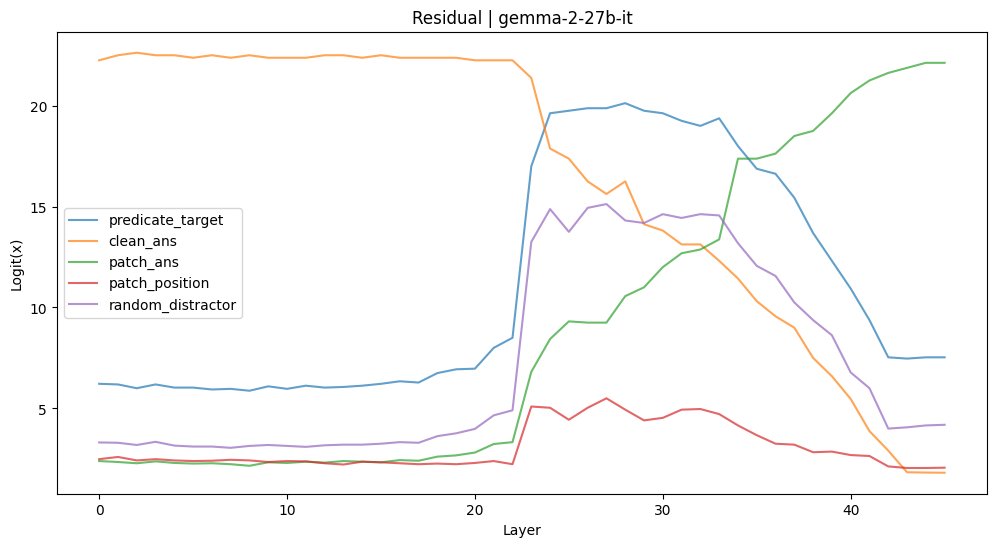

In [16]:
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
for token_type, layerwise_scores_list in scores.items():
    # Compute mean and std deviation across results for each layer
    mean_scores = np.mean(layerwise_scores_list, axis=0)
    sterr_scores = np.std(layerwise_scores_list, axis=0) / np.sqrt(len(layerwise_scores_list))

    plt.plot(mean_scores, label=f"{token_type}", alpha=0.7)
    plt.fill_between(range(len(mean_scores)), mean_scores - sterr_scores, mean_scores + sterr_scores, alpha=0.2)

plt.xlabel("Layer")
plt.ylabel("Logit(x)")
plt.title(f"Residual | {mt.name.split('/')[-1]}")
plt.legend()
plt.show()

## Patching to check if there is an answer flag

In [17]:
from src.selection.utils import verify_correct_option

def get_counterfactual_sample_with_answer_flag(
    mt: ModelandTokenizer,
    task: SelectOneTask,
    clean_category: str = "fruit",
    patch_category: str = "vehicle",
    flag_category: str = "animal",
    prompt_template_idx = 3,
    retry_count: int = 0,
):
    distractor_categories = random.sample(list(
        set(select_task.category_wise_examples.keys())
        - {clean_category, patch_category, flag_category}
    ), k=N_DISTRACTORS - 3)

    clean_obj = random.choice(select_task.category_wise_examples[clean_category])
    patch_obj = random.choice(select_task.category_wise_examples[patch_category])
    flag_obj = random.choice(select_task.category_wise_examples[flag_category])

    logger.info(f"{clean_obj=}, {patch_obj=}, {flag_obj=}")

    options = [clean_obj, patch_obj, flag_obj]

    for category in distractor_categories:
        options.append(random.choice(select_task.category_wise_examples[category]))

    random.shuffle(options)

    random_obj = random.choice(
        list(
            set(options)
            - {clean_obj, patch_obj, flag_obj}
        )
    )
    logger.info(f"{random_obj=}")
    logger.info(f"{options=}")

    clean_sample = SelectionSample(
        obj = clean_obj,
        obj_idx = options.index(clean_obj),
        options = options,
        answer=clean_obj,
        category=clean_category,
        ans_token_id=get_first_token_id(name=clean_obj, tokenizer=mt.tokenizer, prefix=" "),
        prompt_template=select_task.prompt_templates[prompt_template_idx],
        default_option_style=OPTION_STYLE,
    )

    patch_sample = SelectionSample(
        obj = patch_obj,
        obj_idx = options.index(patch_obj),
        options = options,
        answer=patch_obj,   
        category=patch_category,
        ans_token_id=get_first_token_id(name=patch_obj, tokenizer=mt.tokenizer, prefix=" "),
        prompt_template=select_task.prompt_templates[prompt_template_idx],
        default_option_style=OPTION_STYLE,
    )

    flag_sample = SelectionSample(
        obj = flag_obj,
        obj_idx = options.index(flag_obj),
        options = options,
        answer=flag_obj,   
        category=flag_category,
        ans_token_id=get_first_token_id(name=flag_obj, tokenizer=mt.tokenizer, prefix=" "),
        prompt_template=select_task.prompt_templates[prompt_template_idx],
        default_option_style=OPTION_STYLE,
    )

    for sample in [clean_sample, patch_sample, flag_sample]:
        is_correct, pred, track_objs = verify_correct_option(
            mt=mt,
            input=sample.prompt(),
            target=sample.ans_token_id,
            options=sample.options
        )

        if not is_correct:
            logger.error(
                f"""Sample = {sample}
Top prediction {track_objs[list(track_objs.keys())[0]]} does not match the object {sample.obj}[{sample.ans_token_id}, "{mt.tokenizer.decode(sample.ans_token_id)}"].
Retry count: {retry_count + 1}. Retrying ...
"""
            )
            return get_counterfactual_sample_with_answer_flag(
                mt=mt,
                task=task,
                clean_category=clean_category,
                patch_category=patch_category,
                flag_category=flag_category,
                prompt_template_idx=prompt_template_idx,
                retry_count=retry_count + 1,
            )
        
    return clean_sample, patch_sample, flag_sample

clean_sample, patch_sample, flag_sample = get_counterfactual_sample_with_answer_flag(
    mt=mt,
    task=select_task,
    clean_category="fruit",
    patch_category="vehicle",
    flag_category="animal",
    prompt_template_idx=2,
    retry_count=0,
)

2025-09-09 17:32:27 __main__ INFO     clean_obj='Cherry', patch_obj='Tractor', flag_obj='Horse'
2025-09-09 17:32:27 __main__ INFO     random_obj='Spruce'
2025-09-09 17:32:27 __main__ INFO     options=['Horse', 'Spruce', 'Cherry', 'Skyscraper', 'Tractor']


In [18]:
from src.tokens import find_token_range


def locate_with_delim(prompt, option):
    st = prompt.index(option)
    return prompt[st : st + len(option) + 1]


def layer_wise_patch_with_ablating_ans(
    mt: ModelandTokenizer,
    clean_sample: SelectionSample,
    patch_sample: SelectionSample,
    flag_sample: SelectionSample,
    pred_token_indices=[-2, -1],
    ablate_ans_flag: bool = True,
):
    interested_tokens = {
        "clean_ans": get_first_token_id(clean_sample.obj, mt.tokenizer, prefix=" "),
        "patch_ans": get_first_token_id(patch_sample.obj, mt.tokenizer, prefix=" "),
        "flag_ans": get_first_token_id(flag_sample.obj, mt.tokenizer, prefix=" "),
        "random_obj": get_first_token_id(
            random.choice(
                list(
                    set(clean_sample.options)
                    - {clean_sample.obj, patch_sample.obj, flag_sample.obj}
                )
            ),
            mt.tokenizer,
            prefix=" ",
        ),
    }
    clean_tokenized = prepare_input(
        tokenizer=mt, prompts=clean_sample.prompt(), return_offsets_mapping=True
    )
    clean_offset_mapping = clean_tokenized.pop("offset_mapping")[0]

    logit_location = (mt.lm_head_name, -1)
    # clean_run
    clean_logits = get_hs(
        mt=mt,
        input=clean_tokenized,
        locations=[logit_location],
        return_dict=False,
    ).squeeze()
    clean_pred, clean_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=clean_logits,
        interested_tokens=interested_tokens.values(),
    )
    logger.debug(f"clean_pred={[str(pred) for pred in clean_pred]}")
    logger.debug(f"clean_track={clean_track}")

    # patch_run
    patch_tokenized = prepare_input(
        tokenizer=mt, prompts=patch_sample.prompt(), return_offsets_mapping=True
    )
    patch_offset_mapping = patch_tokenized.pop("offset_mapping")[0]
    pred_locations = list(product(mt.layer_names, pred_token_indices))
    pred_hs_from_patch = get_hs(
        mt=mt,
        input=patch_tokenized,
        locations=pred_locations + [logit_location],
        return_dict=True,
    )
    patch_logits = pred_hs_from_patch[logit_location]
    patch_pred, patch_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=patch_logits,
        interested_tokens=interested_tokens.values(),
    )
    logger.debug(f"patch_pred={[str(pred) for pred in patch_pred]}")
    logger.debug(f"patch_track={patch_track}")

    # flag run
    flag_tokenized = prepare_input(
        prompts=flag_sample.prompt(), tokenizer=mt, return_offsets_mapping=True
    )
    flag_offset_mapping = flag_tokenized.pop("offset_mapping")[0]

    flag_token_indices = []
    opt_ranges = []

    for option in flag_sample.options:
        delim_option = locate_with_delim(flag_sample.prompt(), option)
        flag_opt_range = find_token_range(
            string=flag_sample.prompt(),
            substring=delim_option,
            tokenizer=mt.tokenizer,
            offset_mapping=flag_offset_mapping,
        )
        clean_opt_range = find_token_range(
            string=clean_sample.prompt(),
            substring=delim_option,
            tokenizer=mt.tokenizer,
            offset_mapping=clean_offset_mapping,
        )
        logger.debug(
            f'"{option}" | in_flag="{mt.tokenizer.decode(flag_tokenized.input_ids[0][range(*flag_opt_range)])}" | in_clean="{mt.tokenizer.decode(clean_tokenized.input_ids[0][range(*clean_opt_range)])}"'
        )
        assert (
            flag_opt_range[1] - flag_opt_range[0]
            == clean_opt_range[1] - clean_opt_range[0]
        )
        opt_ranges.append((flag_opt_range, clean_opt_range))
        flag_token_indices.extend(list(range(*flag_opt_range)))

    flag_token_indices = sorted(set(flag_token_indices))
    flag_locations = list(product(mt.layer_names, flag_token_indices))

    option_hs_from_flag = get_hs(
        mt=mt,
        input=flag_tokenized,
        locations=flag_locations + [logit_location],
        return_dict=True,
    )

    flag_pred, flag_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=option_hs_from_flag[logit_location],
        interested_tokens=interested_tokens.values(),
    )
    logger.debug(f"flag_pred={[str(pred) for pred in flag_pred]}")
    logger.debug(f"flag_track={flag_track}")

    option_patches = []
    for option_idx in range(len(flag_sample.options)):
        flag_opt_range, clean_opt_range = opt_ranges[option_idx]
        for flag_tok_idx, clean_tok_idx in zip(
            range(*flag_opt_range), range(*clean_opt_range)
        ):
            option_patches.extend(
                [
                    PatchSpec(
                        location=(layer, clean_tok_idx),
                        patch=option_hs_from_flag[(layer, flag_tok_idx)],
                    )
                    for layer in mt.layer_names
                ]
            )

    layerwise_patching_results = {}
    for layer in mt.layer_names:
        patch_spec = []
        for tok_idx in pred_token_indices:
            patch_spec.append(
                PatchSpec(
                    location=(layer, tok_idx),
                    patch=pred_hs_from_patch[(layer, tok_idx)],
                )
            )

        int_hs = get_hs(
            mt=mt,
            input=clean_tokenized,
            locations=[logit_location],
            patches=patch_spec + option_patches if ablate_ans_flag else patch_spec,
            return_dict=True,
        )
        int_logits = int_hs[logit_location]
        int_pred, int_track = interpret_logits(
            tokenizer=mt.tokenizer,
            logits=int_logits,
            interested_tokens=interested_tokens.values(),
        )

        logger.debug(f"Layer {layer}: int_pred={[str(pred) for pred in int_pred]}")

        layerwise_patching_results[layer] = {
            "int_pred": int_pred,
            "int_track": int_track,
        }

    return {
        "track_tokens": interested_tokens,
        "clean_pred": clean_pred,
        "clean_track": clean_track,
        "patch_pred": patch_pred,
        "patch_track": patch_track,
        "flag_pred": flag_pred,
        "flag_track": flag_track,
        "layerwise_patching_results": layerwise_patching_results,
    }


patching_result = layer_wise_patch_with_ablating_ans(
    mt=mt,
    clean_sample=clean_sample,
    patch_sample=patch_sample,
    flag_sample=flag_sample,
    pred_token_indices=[-2, -1],
    ablate_ans_flag=True,
)

2025-09-09 17:32:28 __main__ DEBUG    clean_pred=['" Cherry"[44507] (p=0.930, logit=22.000)', '" **"[5231] (p=0.067, logit=19.375)', '"\n\n"[109] (p=0.001, logit=15.500)', '"\n"[108] (p=0.001, logit=14.875)', '"  "[139] (p=0.001, logit=14.562)']
2025-09-09 17:32:28 __main__ DEBUG    clean_track=OrderedDict([(44507, (1, PredictedToken(token=' Cherry', prob=0.9296875, logit=22.0, token_id=44507, metadata=None))), (29572, (45, PredictedToken(token=' Horse', prob=1.4454126358032227e-06, logit=8.625, token_id=29572, metadata=None))), (117413, (487, PredictedToken(token=' Spruce', prob=5.098991096019745e-08, logit=5.28125, token_id=117413, metadata=None))), (131409, (2044, PredictedToken(token=' Tractor', prob=1.100124791264534e-08, logit=3.75, token_id=131409, metadata=None)))])
2025-09-09 17:32:28 __main__ DEBUG    patch_pred=['" Tractor"[131409] (p=0.949, logit=21.875)', '" **"[5231] (p=0.047, logit=18.875)', '"\n\n"[109] (p=0.001, logit=15.375)', '"  "[139] (p=0.001, logit=14.750)', '"\n

In [21]:
limit = 64
prompt_template_idx = 2

test_set = []
while len(test_set) < limit:
    print(f"sample {len(test_set)+1} / {limit}")
    clean_category = random.choice(list(select_task.category_wise_examples.keys()))
    patch_category = random.choice(
        list(
            set(select_task.category_wise_examples.keys()) - {clean_category}
        )
    )
    flag_category = random.choice(
        list(
            set(select_task.category_wise_examples.keys())
            - {clean_category, patch_category}
        )
    )
    clean, patch, flag = get_counterfactual_sample_with_answer_flag(
        mt=mt,
        task=select_task,
        clean_category=clean_category,
        patch_category=patch_category,
        flag_category=flag_category,
        prompt_template_idx=prompt_template_idx,
        retry_count=0,
    )
    test_set.append((clean, patch, flag))

sample 1 / 64
2025-09-09 17:33:51 __main__ INFO     clean_obj='Coat', patch_obj='Guitar', flag_obj='Air fryer'
2025-09-09 17:33:51 __main__ INFO     random_obj='Cufflink'
2025-09-09 17:33:51 __main__ INFO     options=['Golf ball', 'Cufflink', 'Guitar', 'Coat', 'Air fryer']


sample 2 / 64
2025-09-09 17:33:51 __main__ INFO     clean_obj='Xylophone', patch_obj='Pin', flag_obj='Eucalyptus'
2025-09-09 17:33:51 __main__ INFO     random_obj='Library'
2025-09-09 17:33:51 __main__ INFO     options=['Xylophone', 'Eucalyptus', 'Pin', 'Library', 'Giraffe']
sample 3 / 64
2025-09-09 17:33:51 __main__ INFO     clean_obj='Keyboard', patch_obj='Tiger', flag_obj='Tiara'
2025-09-09 17:33:51 __main__ INFO     random_obj='Airplane'
2025-09-09 17:33:51 __main__ INFO     options=['Tiger', 'Tiara', 'Dresser', 'Airplane', 'Keyboard']
sample 4 / 64
2025-09-09 17:33:52 __main__ INFO     clean_obj='Locket', patch_obj='Tablet', flag_obj='Blender'
2025-09-09 17:33:52 __main__ INFO     random_obj='Xylophone'
2025-09-09 17:33:52 __main__ INFO     options=['Tablet', 'Theater', 'Locket', 'Blender', 'Xylophone']
sample 5 / 64
2025-09-09 17:33:52 __main__ INFO     clean_obj='Shirt', patch_obj='Mixer', flag_obj='Chain'
2025-09-09 17:33:52 __main__ INFO     random_obj='Surfboard'
2025-09-09 1

In [22]:
clean_sample, patch_sample, flag_sample = test_set[10]
print(clean_sample.prompt(), ">>", clean_sample.obj)
print(patch_sample.prompt(), ">>", patch_sample.obj)
print(flag_sample.prompt(), ">>", flag_sample.obj)

Which object from the following list is a jewelry?
Options: Bench, Lavender, Earring, Boat, Eraser.
Answer: >> Earring
Which object from the following list is a vehicle?
Options: Bench, Lavender, Earring, Boat, Eraser.
Answer: >> Boat
Which object from the following list is a furniture?
Options: Bench, Lavender, Earring, Boat, Eraser.
Answer: >> Bench


In [23]:
from tqdm.auto import tqdm
results = []

for clean, patch, flag in tqdm(test_set):
    result = layer_wise_patch_with_ablating_ans(
        mt=mt,
        clean_sample=clean,
        patch_sample=patch,
        flag_sample=flag,
        pred_token_indices=[-2, -1],
        ablate_ans_flag=True,
    )
    results.append(result)

  0%|          | 0/64 [00:00<?, ?it/s]

2025-09-09 17:34:29 __main__ DEBUG    clean_pred=['" Coat"[56200] (p=0.945, logit=22.375)', '" **"[5231] (p=0.053, logit=19.500)', '"\n\n"[109] (p=0.001, logit=14.938)', '"Coat"[110324] (p=0.000, logit=14.625)', '"  "[139] (p=0.000, logit=14.625)']
2025-09-09 17:34:29 __main__ DEBUG    clean_track=OrderedDict([(56200, (1, PredictedToken(token=' Coat', prob=0.9453125, logit=22.375, token_id=56200, metadata=None))), (144527, (9, PredictedToken(token=' Cuff', prob=0.00010967254638671875, logit=13.3125, token_id=144527, metadata=None))), (45519, (102, PredictedToken(token=' Guitar', prob=3.2782554626464844e-07, logit=7.5, token_id=45519, metadata=None))), (4252, (391, PredictedToken(token=' Air', prob=5.029141902923584e-08, logit=5.625, token_id=4252, metadata=None)))])
2025-09-09 17:34:29 __main__ DEBUG    patch_pred=['" Guitar"[45519] (p=0.977, logit=23.250)', '" **"[5231] (p=0.023, logit=19.500)', '"\n\n"[109] (p=0.000, logit=14.938)', '"  "[139] (p=0.000, logit=14.812)', '"\n"[108] (p=

In [28]:
# results = [patching_result]
# result

scores = {token_type: [] for token_type in results[0]["track_tokens"].keys()}
for result in results:
    for token_type in scores.keys():
        layerwise_scores = []
        token_id = result["track_tokens"][token_type]
        for layer_idx in range(mt.n_layer):
            score = result["layerwise_patching_results"][mt.layer_names[layer_idx]]["int_track"][token_id][1].logit
            layerwise_scores.append(score)
        scores[token_type].append(layerwise_scores)

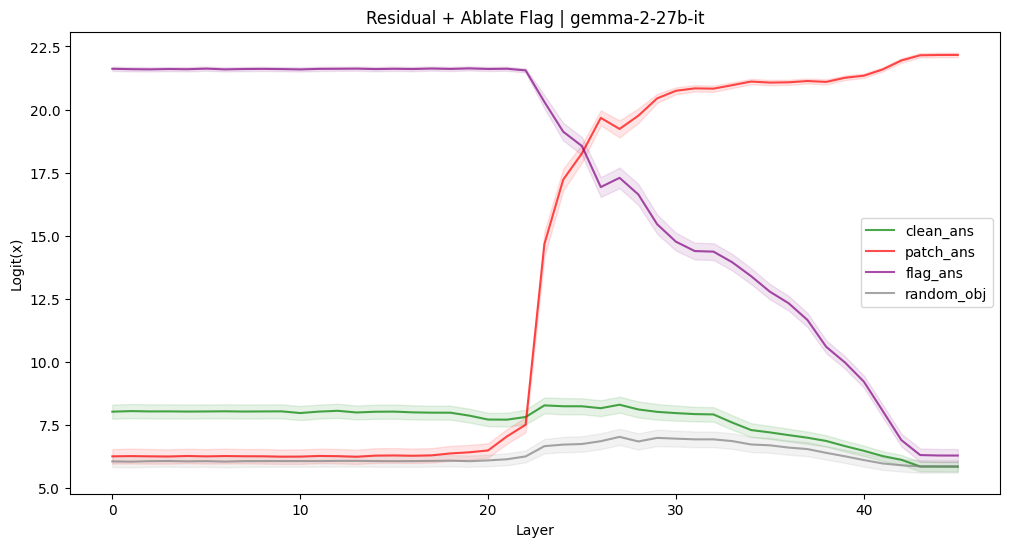

In [29]:
import numpy as np
from matplotlib import pyplot as plt

colors = {
    "clean_ans": "green",
    "patch_ans": "red",
    "flag_ans": "purple",
    "random_obj": "gray",
}

plt.figure(figsize=(12, 6))
for token_type, layerwise_scores_list in scores.items():
    # Compute mean and std deviation across results for each layer
    mean_scores = np.mean(layerwise_scores_list, axis=0)
    sterr_scores = np.std(layerwise_scores_list, axis=0) / np.sqrt(
        len(layerwise_scores_list)
    )

    plt.plot(
        mean_scores,
        label=f"{token_type}",
        alpha=0.7,
        color=colors.get(token_type, None),
    )
    plt.fill_between(
        range(len(mean_scores)),
        mean_scores - sterr_scores,
        mean_scores + sterr_scores,
        alpha=0.1,
        color=colors.get(token_type, None),
    )

plt.xlabel("Layer")
plt.ylabel("Logit(x)")
# plt.title(f"Residual | {mt.name.split('/')[-1]}")
plt.title(f"Residual + Ablate Flag | {mt.name.split('/')[-1]}")
plt.legend()
plt.show()